# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os, glob
%matplotlib inline

In [4]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


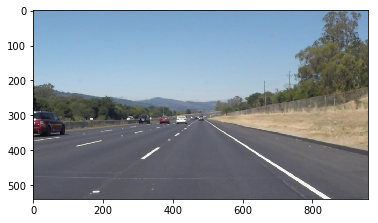

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ 
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

# HI

In [41]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()
    

In [42]:
test_images = [plt.imread(path) for path in glob.glob('test_images/*.jpg')]

In [47]:
import os
rootpath = os.listdir("test_images/")
for filename in rootpath:
     print(filename)
# #     print
#     image = mpimg.imread("test_images/"+filename)
# # print(type(rootpath[1]))
#     plt.imshow(image)
#     plt.show()

solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


solidWhiteCurve.jpg


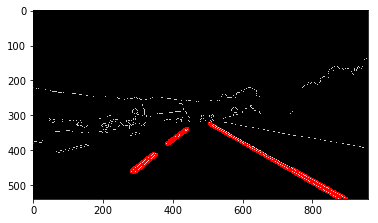

solidWhiteRight.jpg


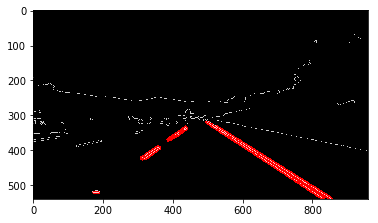

solidYellowCurve.jpg


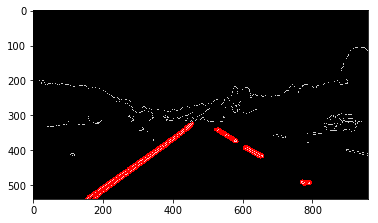

solidYellowCurve2.jpg


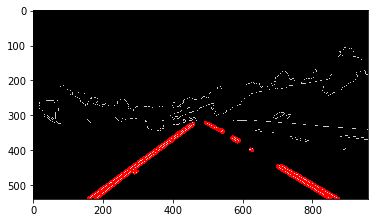

solidYellowLeft.jpg


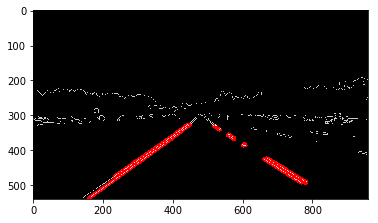

whiteCarLaneSwitch.jpg


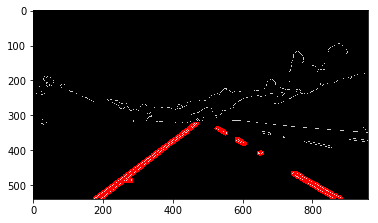

In [48]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
for filename in rootpath:
    print(filename)
#     print
    image = mpimg.imread("test_images/"+filename)
    # Read in and grayscale the image
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),10)
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(150,imshape[0]),(420,330),(500,320), (900,imshape[0])]], dtype=np.int32)
# 
# vertices = np.array([[(0,imshape[0]),(450, 410), (500, 410), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
    rho = 2# distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 0.5 #minimum number of pixels making up a line
#      min_line_length = 50 # resulted in missed lots of segments which had fewer number of pixels
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
#             if y1 > 300 and y2 > 300 and x1<850 and x2<850 and x1>160 and x2>160:
                cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    plt.imshow(lines_edges)
    plt.show()


    
    

run your solution on all test_images and make copies into the test_images directory).

In [25]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2



# Read in and grayscale the image
# Note: in the previous example we were reading a .jpg 
# Here we read a .png and convert to 0,255 bytescale
# image = mpimg.imread('test_images/solidWhiteCurve.jpg')
image = mpimg.imread('test_images/image_test.jpg')
gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
# plt.figure

# Define a kernel size and apply Gaussian smoothing
kernel_size = 7
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
# plt.figure
# plt.imshow(blur_gray)
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges,cmap='gray')
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
# vertices = np.array([[(0,imshape[0]),(390,320),(450,320), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
# 
# vertices = np.array([[(150,imshape[0]),(420,330),(500,320), (900,imshape[0])]], dtype=np.int32)
vertices = np.array([[(0.25*imshape[1],imshape[0]),(0.4*imshape[1],0.7*imshape[0]),(0.45*imshape[1],0.55*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
# print(imshape[1])
print(vertices)

FileNotFoundError: [Errno 2] No such file or directory: 'test_images/image_test.jpg'

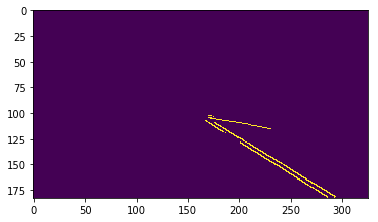

In [259]:

masked_edges = cv2.bitwise_and(edges, mask)
plt.imshow(masked_edges)

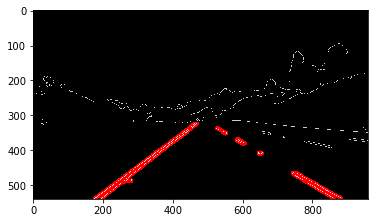

In [26]:

masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 2# distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 1 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)

In [27]:
import math 
# # print(lines[0][0])
# class LineStruct():
#     def __init__(self, x, y, theta):
#         self.x = x
#         self.y = y
#         self.theta = theta
        
# x=y=theta=1
# lanes = LineStruct(x,y,theta)


xright = yright = yleft  =xleft = np.array([])

print(lanes.x)
# left_lines = np.empty()
thereshold_theta = 0.3
for line in lines:
    for x1,y1,x2,y2 in line:
        theta = math.atan2((y2-y1),(x2-x1))
#         left_lines = np.hstack(left_lines,)
        if abs(theta) > thereshold_theta:
#         right lines
            if theta > 0:
                 xright =   np.append(xright,[x1,x2])
                 yright =   np.append(yright,[y1,y2])
            else:
                 xleft =   np.append(xleft,[x1,x2])
                 yleft =   np.append(yleft,[y1,y2])
# 
# (a, c)  y = ax + c
lineparam_left = np.polyfit(xleft,yleft, 1)
(a_l,c_l) = np.polyfit(xleft,yleft, 1)
(a_r,c_r) = np.polyfit(xright,yright, 1)
#  find the x using the H --> x_H = (H-c)/a
x1_r = int((imshape[0]-c_r)/a_r)
y1_r = int(imshape[0])
x1_l = int((imshape[0]-c_l)/a_l)
y1_l= int(imshape[0])
# find the minimum 
ymin1 =np.hstack([yright,yleft])
ymin = ymin1.min()
y2_r = y2_l = int(ymin)

x2_r = np.int((ymin-c_r)/a_r)
x2_l = int((ymin-c_l)/a_l)

# print(yleft)
# import pandas as pd
# l_left = pd.DataFrame(np.random.randn(10, 3), columns=['x', 'y',  'theta'])
# l_right = pd.DataFrame(np.random.randn(10, 3), columns=['x', 'y',  'theta'])
# print(l_left)
# print(l_right)

NameError: name 'lanes' is not defined

In [213]:
cv2.line(line_image,(x2_r,y2_r),(x1_r,y1_r),(255,0,0),20)
cv2.line(line_image,(x2_l,y2_l),(x1_l,y1_l),(255,0,0),20)
# Create a "color" binary image to combine with line image
# color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)



error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/core/src/arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


In [214]:
# weighted_img(lines_edges, gray, α=0.8, β=1., λ=0.)
# plt.imshow(gray, cmap='gray')
# lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
ww = weighted_img(lines_edges, image, α=0.7, β=0.3, λ=60)
plt.imshow(ww)
# plt.imshow(image)

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/core/src/arithm.cpp:639: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [28]:
# Import everything needed to edit/save/watch video clips
import imageio 
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [31]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),4)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    # vertices = np.array([[(0,imshape[0]),(390,320),(450,320), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    # 
#     vertices = np.array([[(150,imshape[0]),(420,330),(500,320), (900,imshape[0])]], dtype=np.int32)
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2# distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 50 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)
    plt.imshow(image)
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 


    xright = yright = yleft  =xleft = np.array([])

#     print(lanes.x)
    # left_lines = np.empty()
    thereshold_theta = 0.3
    for line in lines:
        for x1,y1,x2,y2 in line:
            theta = math.atan2((y2-y1),(x2-x1))
            print(theta)
    #         left_lines = np.hstack(left_lines,)
            if abs(theta) > thereshold_theta:
    #         right lines
                if theta > 0:
                     xright =   np.append(xright,[x1,x2])
                     yright =   np.append(yright,[y1,y2])
                else:
                     xleft =   np.append(xleft,[x1,x2])
                     yleft =   np.append(yleft,[y1,y2])
    # 
    # (a, c)  y = ax + c
    print('================================????????????????==============')
    print(theta)
    print(xleft)
    print(xright)
    lineparam_left = np.polyfit(xleft,yleft, 1)
    (a_l,c_l) = np.polyfit(xleft,yleft, 1)
    (a_r,c_r) = np.polyfit(xright,yright, 1)
    #  find the x using the H --> x_H = (H-c)/a
    x1_r = int((imshape[0]-c_r)/a_r)
    y1_r = int(imshape[0])
    x1_l = int((imshape[0]-c_l)/a_l)
    y1_l= int(imshape[0])
    # find the minimum 
    ymin1 =np.hstack([yright,yleft])
    ymin = ymin1.min()
    y2_r = y2_l = int(ymin)

    x2_r = np.int((ymin-c_r)/a_r)
    x2_l = int((ymin-c_l)/a_l)

    # print(yleft)
    # import pandas as pd
    # l_left = pd.DataFrame(np.random.randn(10, 3), columns=['x', 'y',  'theta'])
    # l_right = pd.DataFrame(np.random.randn(10, 3), columns=['x', 'y',  'theta'])
    # print(l_left)
    # print(l_right)
    cv2.line(line_image,(x2_r,y2_r),(x1_r,y1_r),(255,0,0),20)
    cv2.line(line_image,(x2_l,y2_l),(x1_l,y1_l),(255,0,0),20)
    # Create a "color" binary image to combine with line image
    # color_edges = np.dstack((edges, edges, edges)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    plt.imshow(lines_edges)

    # weighted_img(lines_edges, gray, α=0.8, β=1., λ=0.)
#     plt.imshow(gray, cmap='gray')
    # lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    result = weighted_img(lines_edges, image, α=0.7, β=0.3, λ=60)
#     plt.imshow(ww)
#     plt.imshow(image)

    return result
# process_image(image)

In [34]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))


def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
             
    
# lane_images = []
# for image, lines in zip(test_images, list_of_lines):
#     lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
# show_images(lane_images)


from collections import deque

QUEUE_LENGTH=50

class LaneDetector:
    def __init__(self):
        self.left_lines  = deque(maxlen=QUEUE_LENGTH)
        self.right_lines = deque(maxlen=QUEUE_LENGTH)

    def process(self, image):
        white_yellow = select_white_yellow(image)
        gray         = convert_gray_scale(white_yellow)
        smooth_gray  = apply_smoothing(gray)
        edges        = detect_edges(smooth_gray)
        regions      = select_region(edges)
        lines        = hough_lines(regions)
        left_line, right_line = lane_lines(image, lines)

        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
            return line

        left_line  = mean_line(left_line,  self.left_lines)
        right_line = mean_line(right_line, self.right_lines)

        return draw_lane_lines(image, (left_line, right_line))
    
def process_video(video_input, video_output):
    detector = LaneDetector()

    clip = VideoFileClip(os.path.join('test_videos', video_input))
    processed = clip.fl_image(detector.process)
    processed.write_videofile(os.path.join('output_videos', video_output), audio=False)

Let's try the one with the solid white lane on the right first ...

In [39]:
process_video('solidWhiteRight.mp4', 'yellow.mp4')

NameError: name 'select_white_yellow' is not defined

0.5411096312859325
-0.6494007453600643
0.5253668738153162
0.558981724502742
-0.6321379615289937
-0.6261367182180095
0.5596815660032787
-0.6265274304106754
0.5577088436287925
-0.6494007453600643
0.5516549825285468
0.5414125486035385
================================????????????????==============
0.5414125486035385
[ 392.  446.  203.  274.  187.  299.  197.  302.  389.  443.]
[ 514.  727.  759.  828.  507.  742.  724.  807.  573.  674.  710.  762.
  517.  813.]
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4



  0%|          | 0/222 [00:00<?, ?it/s]

0.5411096312859325
-0.6494007453600643
0.5253668738153162
0.558981724502742
-0.6321379615289937
-0.6261367182180095
0.5596815660032787
-0.6265274304106754
0.5577088436287925
-0.6494007453600643
0.5516549825285468
0.5414125486035385
================================????????????????==============
0.5414125486035385
[ 392.  446.  203.  274.  187.  299.  197.  302.  389.  443.]
[ 514.  727.  759.  828.  507.  742.  724.  807.  573.  674.  710.  762.
  517.  813.]



  1%|          | 2/222 [00:00<00:42,  5.24it/s]

0.5424315699899499
0.5621867439000292
0.5305578870294475
0.5464617228112849
-0.6274882426879329
0.5280744484263596
-0.6453808058275815
0.5637486004187707
0.5317240672588056
0.5325040983018507
0.5375866466587464
================================????????????????==============
0.5375866466587464
[ 187.  278.  204.  289.]
[ 752.  825.  649.  749.  657.  732.  559.  656.  594.  666.  718.  805.
  520.  588.  769.  825.  566.  618.]
0.5585993153435624
0.5419714907472138
-0.6659692373791098
-0.6086893073274117
0.5419992777873311
0.5622848023425469
0.5491529026790107
-0.6498704494119476
================================????????????????==============
-0.6498704494119476
[ 205.  261.  185.  251.  208.  258.]
[ 507.  755.  543.  827.  514.  793.  734.  807.  691.  758.]



  1%|▏         | 3/222 [00:00<00:38,  5.65it/s]

0.5404195002705842
0.5595583943333858
0.5585993153435624
0.53315570550763
0.5414844625942814
================================????????????????==============
0.5414844625942814
[]
[ 513.  828.  507.  788.  696.  808.  568.  629.  551.  827.]


TypeError: expected non-empty vector for x

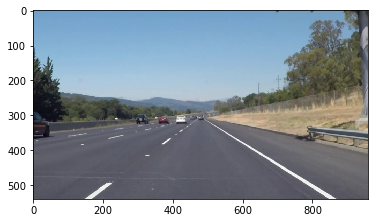

In [40]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

1
0.6086893073274117
0.5627372227610834
-0.5617655316760874
-0.5570207846893974
-0.5612860364446964
0.5633162614919681
0.6220320152891724
================================????????????????==============
0.6220320152891724
[ 277.  447.  329.  443.  269.  436.]
[ 658.  757.  665.  730.  717.  774.  705.  758.]
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4



  0%|          | 2/682 [00:00<00:36, 18.82it/s]

1
0.6086893073274117
0.5627372227610834
-0.5617655316760874
-0.5570207846893974
-0.5612860364446964
0.5633162614919681
0.6220320152891724
================================????????????????==============
0.6220320152891724
[ 277.  447.  329.  443.  269.  436.]
[ 658.  757.  665.  730.  717.  774.  705.  758.]
1
0.6097383103893602
-0.5617655316760874
-0.5435873883006567
0.5763752205911837
-0.5349550737860964
0.5667292175235064
-0.5611634122883522
0.5847452860775617
================================????????????????==============
0.5847452860775617
[ 264.  434.  318.  457.  317.  371.  273.  448.]
[ 678.  814.  689.  789.  729.  784.  704.  775.]
1
-0.5617655316760874
0.5766609348691234
0.6101317873943674
-0.5624979310690725
-0.5576321976566884
0.6007137833109938
-0.5506755509122512
0.5783254862804168
0.6202494859828215
================================????????????????==============
0.6202494859828215
[ 271.  441.  308.  446.  342.  435.  300.  357.]
[ 716.  839.  705.  818.  703.  757.  766. 

1
-0.5749679600509747
-0.5657014686561778
0.6037493333974364
0.5747758616989802
-0.5456550545269917
-0.5939726818721051
0.6190660545826282
0.5767985905912907
0.6132073488745093
-0.556901524105586
-0.5971766580926775
================================????????????????==============
-0.5971766580926775
[ 246.  371.  318.  381.  402.  458.  375.  452.  305.  358.  379.  454.]
[ 738.  796.  752.  840.  739.  819.  755.  838.  738.  819.]



  1%|          | 4/682 [00:00<00:40, 16.69it/s]

1
-0.5593297754035644
-0.5750722897323907
-0.5770381306697496
================================????????????????==============
-0.5770381306697496
[ 292.  415.  242.  350.  233.  445.]
[]


TypeError: expected non-empty vector for x

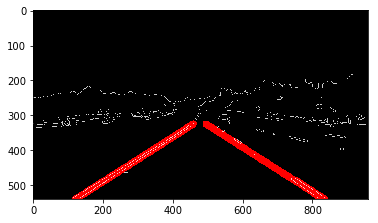

In [191]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [192]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))